In [1]:
#libraries
import sys
import collections
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mode
from scipy.spatial.distance import squareform
import seaborn as sns
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import Imputer
from sklearn import preprocessing
from sklearn import utils
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale
from sklearn import tree
import collections
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

plt.style.use('bmh')
%matplotlib inline

C:\Users\sadeeb\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#import the dataset
pet = pd.read_csv('data/train_features_w_state_info.csv', sep = ',')
pet['has_name'] = pet['Name'].fillna('no_name').apply(lambda x: True if x!='no_name' else False)
pet['has_many_colors'] = np.where(((pet.Color1_Name != '0') & (pet.Color2_Name != '0') & (pet.Color3_Name != '0'))
                                  | (pet.Color1_Name != '0') & (pet.Color2_Name != '0')
                                  | (pet.Color2_Name != '0') & (pet.Color3_Name != '0')
                                  , True, False)
pet['has_description'] =  pet['Description'].fillna('No Description').apply(lambda x: True if x!='No Description' else False)
pet['has_fee'] = pet['Fee'].apply(lambda x: True if x != 0 else False)
pet.describe()

,Type,Age,Age_Yr,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,State,VideoAmt,PhotoAmt,AdoptionSpeed,Population,TotalArea(km2),HDI,Population_Density,2017GDPpercapita_USD,2017GDPpercapita_RM
count,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,...,14993.000000,14993.000000,14993.000000,14993.000000,1.499300e+04,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000
mean,1.457547,10.452078,0.651637,265.287267,74.009738,1.776162,2.234176,3.222837,1.882012,1.862002,...,41346.028347,0.056760,3.889215,2.516441,4.212681e+06,6726.458747,0.814669,2395.926644,15818.693991,62912.072634
std,0.498211,18.155790,1.558780,60.024977,123.011575,0.681592,1.745225,2.742562,2.984086,0.547959,...,32.444153,0.346185,3.487810,1.177265,1.991900e+06,6973.628714,0.013912,2878.851275,7254.001448,28848.942564
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,...,41324.000000,0.000000,0.000000,0.000000,9.680000e+04,91.000000,0.674000,21.181197,3417.000000,13593.000000
25%,1.000000,2.000000,0.000000,265.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,...,41326.000000,0.000000,2.000000,2.000000,1.768000e+06,243.000000,0.819000,724.839585,12092.000000,48091.000000
50%,1.000000,3.000000,0.000000,266.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,...,41326.000000,0.000000,3.000000,2.000000,5.874100e+06,8104.000000,0.819000,724.839585,12092.000000,48091.000000
75%,2.000000,12.000000,1.000000,307.000000,179.000000,2.000000,3.000000,6.000000,5.000000,2.000000,...,41401.000000,0.000000,5.000000,4.000000,5.874100e+06,8104.000000,0.822000,7275.720165,27991.000000,111321.000000
max,2.000000,255.000000,21.000000,307.000000,307.000000,3.000000,7.000000,7.000000,7.000000,4.000000,...,41415.000000,8.000000,30.000000,4.000000,5.874100e+06,124450.000000,0.822000,7275.720165,27991.000000,111321.000000


In [3]:
#check for missing
#% of columns that are NA
columns = pet.columns
percent_missing = pet.isnull().sum() * 100 / len(pet)
missing_value_df = pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df

#name is missing - remove column from final training set

,column_name,percent_missing
Type,Type,0.000000
Health,Health,0.000000
Health_Name,Health_Name,0.000000
Quantity,Quantity,0.000000
Fee,Fee,0.000000
State,State,0.000000
State_Label,State_Label,0.000000
RescuerID,RescuerID,0.000000
VideoAmt,VideoAmt,0.000000
PetID,PetID,0.000000


In [4]:
train_image_data = pd.read_csv('data/train_image.csv')
train_image_data['PetID'] = train_image_data['image'].apply(lambda x: x.split('-')[0])
train_image_data.head()

,image,dullness_whiteness,dullness,whiteness,average_pixel_width,image_size,temp_size,width,height,blurrness,colorfulness,PetID
0,0008c5398-1.jpg,"(5.285, 0.0)",5.285,0.0,0.0,23966,"(349, 479)",349,479,245.576187,152.711515,0008c5398
1,000a290e4-1.jpg,"(0.0, 0.0)",0.000,0.0,0.0,40076,"(360, 480)",360,480,1628.075039,63.306308,000a290e4
2,000fb9572-1.jpg,"(28.18, 0.0)",28.180,0.0,0.0,17985,"(400, 268)",400,268,462.087709,87.689116,000fb9572
3,0011d7c25-1.jpg,"(45.615, 0.0)",45.615,0.0,0.0,22383,"(299, 400)",299,400,760.934114,157.047352,0011d7c25
4,00156db4a-1.jpg,"(2.385, 0.0)",2.385,0.0,0.0,13293,"(400, 267)",400,267,275.050063,114.374175,00156db4a


In [5]:
print(train_image_data.shape)

(14652, 12)


In [6]:
pet = pd.merge(left = pet, right = train_image_data, how = 'left', on = 'PetID')

In [7]:
pet.head()

,Type,Type_Name,Name,Age,Age_Yr,Breed1,Breed1_Name,Breed2,Breed2_Name,Gender,...,dullness_whiteness,dullness,whiteness,average_pixel_width,image_size,temp_size,width,height,blurrness,colorfulness
0,2,Cat,Nibble,3,0,299,Tabby,0,0,1,...,"(21.955000000000002, 1.035)",21.955,1.035,0.0,24638.0,"(360, 480)",360.0,480.0,672.771047,180.252821
1,2,Cat,No Name Yet,1,0,265,Domestic Medium Hair,0,0,1,...,"(24.045, 3.4)",24.045,3.400,0.0,25660.0,"(399, 377)",399.0,377.0,454.006659,137.385071
2,1,Dog,Brisco,1,0,307,Mixed Breed,0,0,1,...,"(0.0, 0.0)",0.000,0.000,0.0,13067.0,"(300, 400)",300.0,400.0,60.519822,179.115326
3,1,Dog,Miko,4,0,307,Mixed Breed,0,0,2,...,"(27.645, 3.155)",27.645,3.155,0.0,22811.0,"(400, 300)",400.0,300.0,502.303825,125.600847
4,1,Dog,Hunter,1,0,307,Mixed Breed,0,0,1,...,"(15.77, 0.0)",15.770,0.000,0.0,32918.0,"(640, 427)",640.0,427.0,363.978801,71.666774


In [8]:
pet.dtypes

Type                      int64
Type_Name                object
Name                     object
Age                       int64
Age_Yr                    int64
Breed1                    int64
Breed1_Name              object
Breed2                    int64
Breed2_Name              object
Gender                    int64
Gender_Name              object
Color1                    int64
Color1_Name              object
Color2                    int64
Color2_Name              object
Color3                    int64
Color3_Name              object
MaturitySize              int64
MaturitySize_Name        object
FurLength                 int64
FurLength_Name           object
Vaccinated                int64
Vaccinated_Name          object
Dewormed                  int64
Dewormed_Name            object
Sterilized                int64
Sterilized_Name          object
Health                    int64
Health_Name              object
Quantity                  int64
                         ...   
State_La

In [9]:
X_features = ['Type', 'has_name', 'Age', 'Breed1_Name', 'Breed2_Name', 'Gender_Name',
              'Color1_Name', 'Color2_Name', 'Color3_Name', 'has_many_colors', 'has_description','MaturitySize_Name',
              'FurLength_Name', 'Vaccinated_Name',  'Dewormed_Name', 'Sterilized_Name', 'Health_Name', 'Quantity',
              'Fee', 'has_fee', 'State_Label', 'VideoAmt', 'PhotoAmt', 'StateorTerritory', 'Population',
              'TotalArea(km2)', 'Region', 'HDI', 'Population_Density','2017GDPpercapita_USD', '2017GDPpercapita_RM',
              'dullness', 'whiteness','image_size', 'width', 'height', 'blurrness', 'colorfulness', 'AdoptionSpeed'] #RescuerID
modeling_features = pd.get_dummies(pet[X_features])
all_features = modeling_features.columns.tolist()

In [10]:
###################### Modeling ######################

#dataprep

#split into X & Y

X = modeling_features[all_features].drop('AdoptionSpeed', axis = 1)
X.replace(' ', '')
Y = modeling_features['AdoptionSpeed']
Y = Y.astype('int')

#split data into test and train
validation_size = .2
random_seed = 1234

X.fillna(0, inplace=True)

x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size = validation_size, random_state = random_seed)


In [11]:
X.dtypes

Type                              int64
has_name                           bool
Age                               int64
has_many_colors                    bool
has_description                    bool
Quantity                          int64
Fee                               int64
has_fee                            bool
VideoAmt                          int64
PhotoAmt                          int64
Population                        int64
TotalArea(km2)                    int64
HDI                             float64
Population_Density              float64
2017GDPpercapita_USD              int64
2017GDPpercapita_RM               int64
dullness                        float64
whiteness                       float64
image_size                      float64
width                           float64
height                          float64
blurrness                       float64
colorfulness                    float64
Breed1_Name_0                     uint8
Breed1_Name_Abyssinian            uint8


In [12]:
def Cmatrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat

def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings

def quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = Cmatrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

In [13]:
def kfold_cross_validation(X,y, col_names):
    #ten cross-validation employed here

    # specify the k-fold cross-validation design
    N_FOLDS = 10
    
    random_seed = 1234
    
    # set up numpy array for storing results
    cv_results = np.zeros((N_FOLDS, len(col_names)))

    kf = model_selection.KFold(n_splits = N_FOLDS, random_state = random_seed)

    index_for_fold = 0 #fold count initialized

    for train_index, test_index in kf.split(X,y):
        print('\nFold index:', index_for_fold + 1,
             '------------------------------------------')
        X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

        print('\nShape of input data for this fold:',
              '\nData Set: (Observations, Variables)')
        print('X_train:', X_train.shape)
        print('X_test:',X_test.shape)
        print('y_train:', y_train.shape)
        print('y_test:',y_test.shape)

        index_for_method = 0 #initialize
        for name, reg_model in zip(col_names, models):
            print('\nRegression model evaluation for:', name)
            print(' Scikit Learn method:', reg_model)
            reg_model.fit(X_train, y_train) #fit on the train set for this fold

            #evaluate on the test set for this fold
            y_test_predict = reg_model.predict(X_test)

            fold_method_result = quadratic_weighted_kappa(y_test, y_test_predict)

            cv_results[index_for_fold, index_for_method] = fold_method_result
            index_for_method += 1

        
        cv_results_df = pd.DataFrame(cv_results)
        cv_results_df.columns = col_names
        index_for_fold += 1
    return cv_results_df

In [14]:
col_names = ['LR','CART','NB']
models = [LogisticRegression(), DecisionTreeClassifier(), GaussianNB()]

In [15]:
ten_fold_cv_models = kfold_cross_validation(X, Y, col_names)


Fold index: 1 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (11994, 393)
X_test: (2999, 393)
y_train: (11994,)
y_test: (2999,)

Regression model evaluation for: LR
 Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Regression model evaluation for: CART
 Scikit Learn method: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Regression model evaluation for: NB
 Scikit Learn method:


Fold index: 9 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (11994, 393)
X_test: (2999, 393)
y_train: (11994,)
y_test: (2999,)

Regression model evaluation for: LR
 Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Regression model evaluation for: CART
 Scikit Learn method: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Regression model evaluation for: NB
 Scikit Learn method:

In [16]:
# average quadratic weighted kappa score over 10 Folds
ten_fold_cv_models.mean()

LR      0.066437
CART    0.196498
NB      0.087116
dtype: float64

In [17]:
LR = LogisticRegression(C=1, multi_class='multinomial', solver = 'lbfgs')
LR.fit(x_train, y_train)
predictions_LR = LR.predict(x_test)
#how accuracy is it?
print("Quadratic Weighted Kappa Score \n", quadratic_weighted_kappa(y_test, predictions_LR))
print("Accuracy Score \n", accuracy_score(y_test, predictions_LR))
print("Confusion Matrix", "\n",  confusion_matrix(y_test, predictions_LR))
print("Classification Report", "\n", classification_report(y_test, predictions_LR))

Quadratic Weighted Kappa Score 
 0.07966268009902344
Accuracy Score 
 0.3051017005668556
Confusion Matrix 
 [[  0   0  49   0  32]
 [  0   0 343   0 249]
 [  0   0 445   0 361]
 [  0   0 347   0 296]
 [  0   0 407   0 470]]
Classification Report 
              precision    recall  f1-score   support

          0       0.00      0.00      0.00        81
          1       0.00      0.00      0.00       592
          2       0.28      0.55      0.37       806
          3       0.00      0.00      0.00       643
          4       0.33      0.54      0.41       877

avg / total       0.17      0.31      0.22      2999



C:\Users\sadeeb\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [18]:
# looking at Decision Tree Classifier
DT = DecisionTreeClassifier()
DT.fit(x_train, y_train)
predictions_DT = DT.predict(x_test)

#how accuracy is it?
print("Quadratic Weighted Kappa Score \n", quadratic_weighted_kappa(y_test, predictions_DT))
print("Accuracy Score \n", accuracy_score(y_test, predictions_DT))
print("Confusion Matrix", "\n",  confusion_matrix(y_test, predictions_DT))
print("Classification Report", "\n", classification_report(y_test, predictions_DT))

Quadratic Weighted Kappa Score 
 0.2032607949021168
Accuracy Score 
 0.33977992664221407
Confusion Matrix 
 [[  2  27  24  14  14]
 [ 17 167 161 113 134]
 [ 21 174 250 194 167]
 [ 16 112 158 199 158]
 [ 21 124 171 160 401]]
Classification Report 
              precision    recall  f1-score   support

          0       0.03      0.02      0.03        81
          1       0.28      0.28      0.28       592
          2       0.33      0.31      0.32       806
          3       0.29      0.31      0.30       643
          4       0.46      0.46      0.46       877

avg / total       0.34      0.34      0.34      2999



In [19]:
NB = GaussianNB()
NB.fit(x_train, y_train)
predictions_NB = NB.predict(x_test)
#how accuracy is it?
print("Quadratic Weighted Kappa Score \n", quadratic_weighted_kappa(y_test, predictions_NB))
print("Accuracy Score \n", accuracy_score(y_test, predictions_NB))
print("Confusion Matrix", "\n",  confusion_matrix(y_test, predictions_NB))
print("Classification Report", "\n", classification_report(y_test, predictions_NB))

Quadratic Weighted Kappa Score 
 0.053206707577341805
Accuracy Score 
 0.2997665888629543
Confusion Matrix 
 [[  3   1  47   4  26]
 [  1  15 362  23 191]
 [  4  19 481  37 265]
 [  8  16 390  23 206]
 [ 25  18 430  27 377]]
Classification Report 
              precision    recall  f1-score   support

          0       0.07      0.04      0.05        81
          1       0.22      0.03      0.05       592
          2       0.28      0.60      0.38       806
          3       0.20      0.04      0.06       643
          4       0.35      0.43      0.39       877

avg / total       0.27      0.30      0.24      2999



In [20]:
#train the algorithm

RF = RandomForestClassifier(n_estimators = 100,
                                    max_features = 'log2',
                                    bootstrap = False,
                                    random_state = random_seed)
RF.fit(x_train, y_train)
y_pred_RF = RF.predict(x_test)

#how accuracy is it?
print("Quadratic Weighted Kappa Score \n", quadratic_weighted_kappa(y_test, y_pred_RF))
print("Accuracy Score \n", accuracy_score(y_test, y_pred_RF))
print("Confusion Matrix", "\n",  confusion_matrix(y_test, y_pred_RF))
print("Classification Report", "\n", classification_report(y_test, y_pred_RF))

Quadratic Weighted Kappa Score 
 0.3463831909567926
Accuracy Score 
 0.4214738246082027
Confusion Matrix 
 [[  3  20  27  11  20]
 [  4 203 197  60 128]
 [  3 175 322 122 184]
 [  2  87 190 172 192]
 [  3  72 176  62 564]]
Classification Report 
              precision    recall  f1-score   support

          0       0.20      0.04      0.06        81
          1       0.36      0.34      0.35       592
          2       0.35      0.40      0.37       806
          3       0.40      0.27      0.32       643
          4       0.52      0.64      0.57       877

avg / total       0.41      0.42      0.41      2999



Text(0.5,1,'Feature importance')

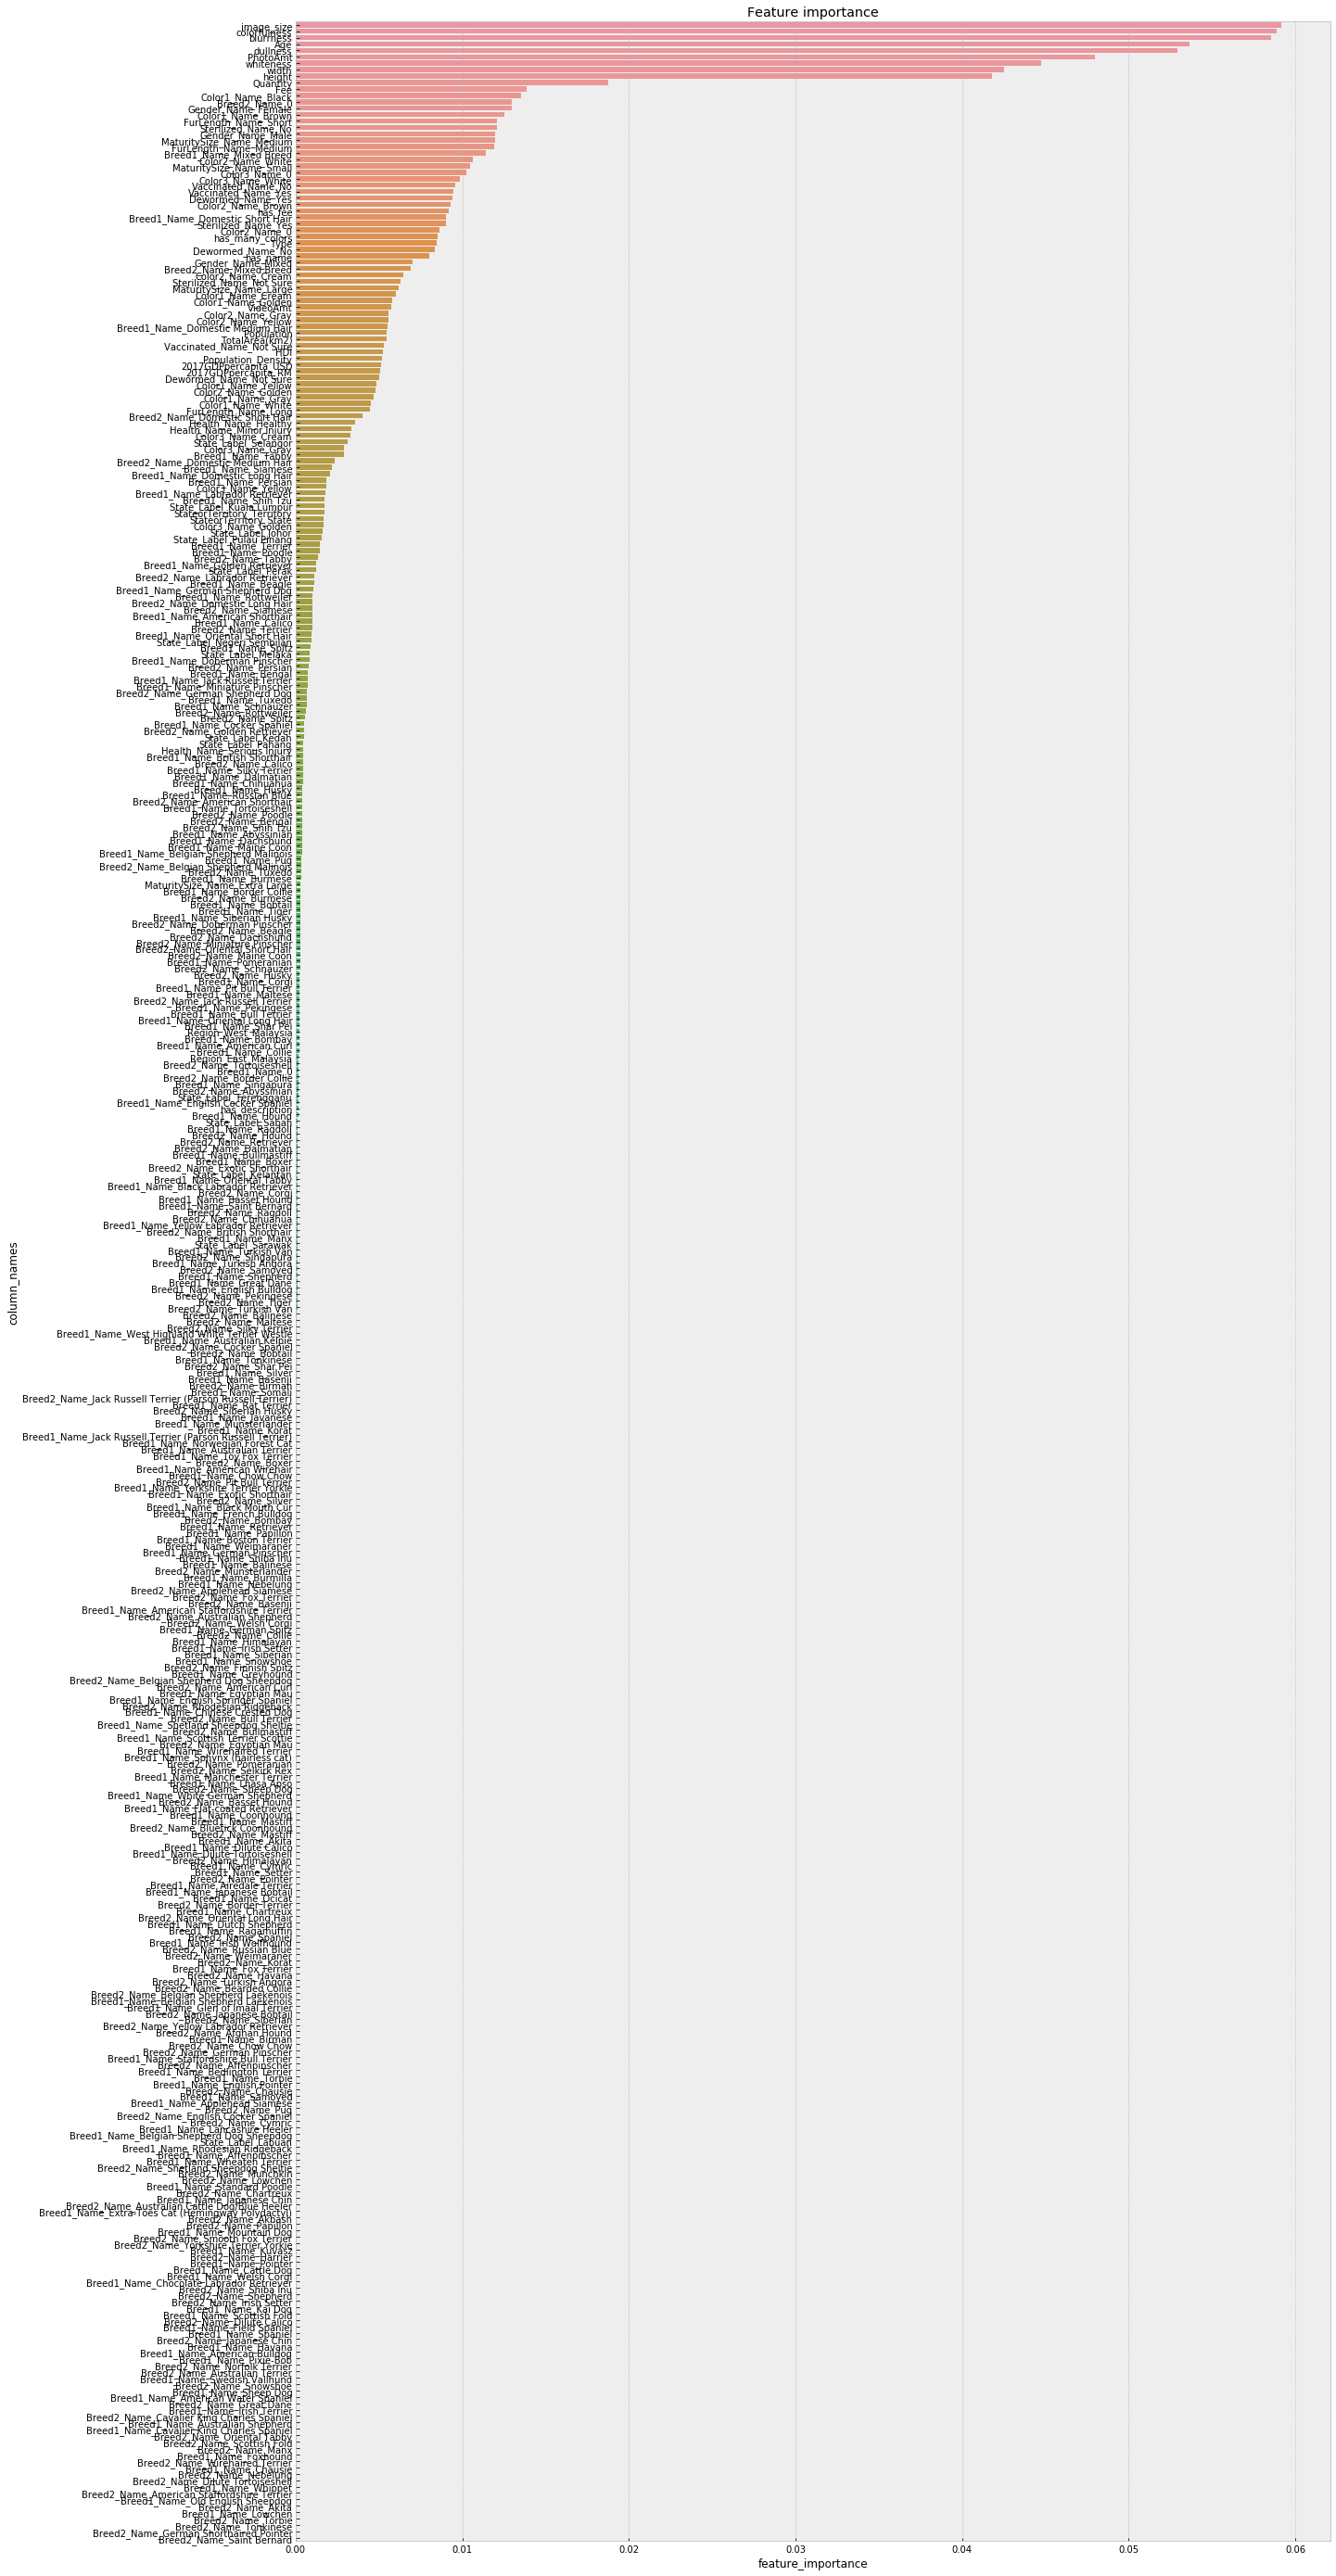

In [21]:
RF_feature_importance_df = pd.DataFrame({"column_names":x_train.columns, "feature_importance": RF.feature_importances_})
RF_feature_importance_df = RF_feature_importance_df.sort_values('feature_importance',ascending=False)
f, ax = plt.subplots(figsize=(20, 50))
sns.barplot(x="feature_importance", y="column_names", data=RF_feature_importance_df)
plt.title('Feature importance')

C:\Users\sadeeb\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Text(0.5,1,'Top 25 Feature importance')

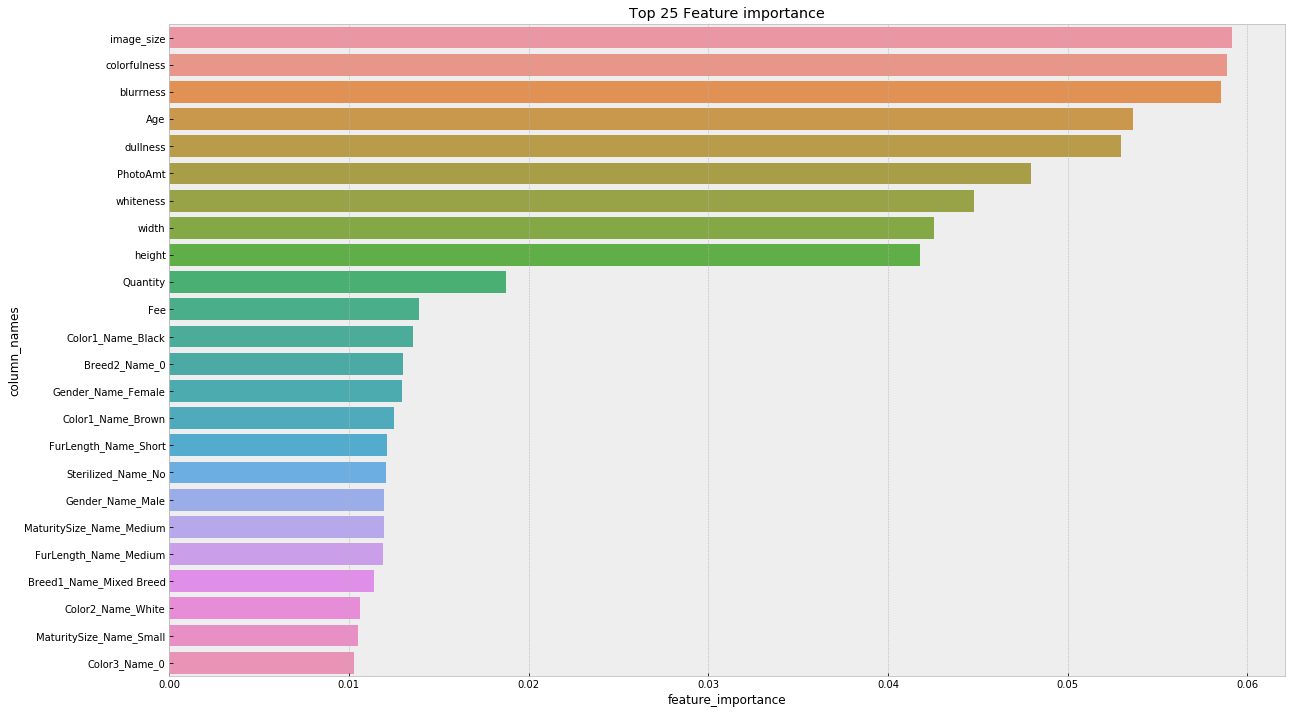

In [22]:
RF_feature_importance_df_filtered = (RF_feature_importance_df.sort_values('feature_importance',ascending=False)
                                     [RF_feature_importance_df['feature_importance']>=0.01])
f, ax = plt.subplots(figsize=(20, 12))
sns.barplot(x="feature_importance", y="column_names", data=RF_feature_importance_df_filtered)
plt.title('Top 25 Feature importance')

In [23]:
import xgboost as xgb

In [24]:
d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_test, label=y_test)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

xgb_params = {'objective' : 'multi:softmax',
              'eval_metric' : 'mlogloss',
              'eta' : 0.05,
              'max_depth' : 4,
              'num_class' : 5,
              'lambda' : 0.8
}

num_round = 1000 

print('Fitting XGBoost')

bst = xgb.train(xgb_params, 
                d_train, 
                num_round, 
                watchlist, 
                early_stopping_rounds=50, 
                verbose_eval=0)

print('Predicting')

y_pred_XGB = bst.predict(xgb.DMatrix(x_test)).astype(int)

print("Quadratic Weighted Kappa Score \n", quadratic_weighted_kappa(y_test, y_pred_XGB))
print("Accuracy Score \n", accuracy_score(y_test, y_pred_RF))
print("Confusion Matrix", "\n",  confusion_matrix(y_test, y_pred_XGB))
print("Classification Report", "\n", classification_report(y_test, y_pred_XGB))

C:\Users\sadeeb\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Fitting XGBoost
Predicting
Quadratic Weighted Kappa Score 
 0.3756452456692838
Accuracy Score 
 0.4214738246082027
Confusion Matrix 
 [[  0  29  30   3  19]
 [  3 193 236  51 109]
 [  0 157 347  88 214]
 [  0 107 211 122 203]
 [  3  62 163  60 589]]
Classification Report 
              precision    recall  f1-score   support

          0       0.00      0.00      0.00        81
          1       0.35      0.33      0.34       592
          2       0.35      0.43      0.39       806
          3       0.38      0.19      0.25       643
          4       0.52      0.67      0.59       877

avg / total       0.40      0.42      0.40      2999



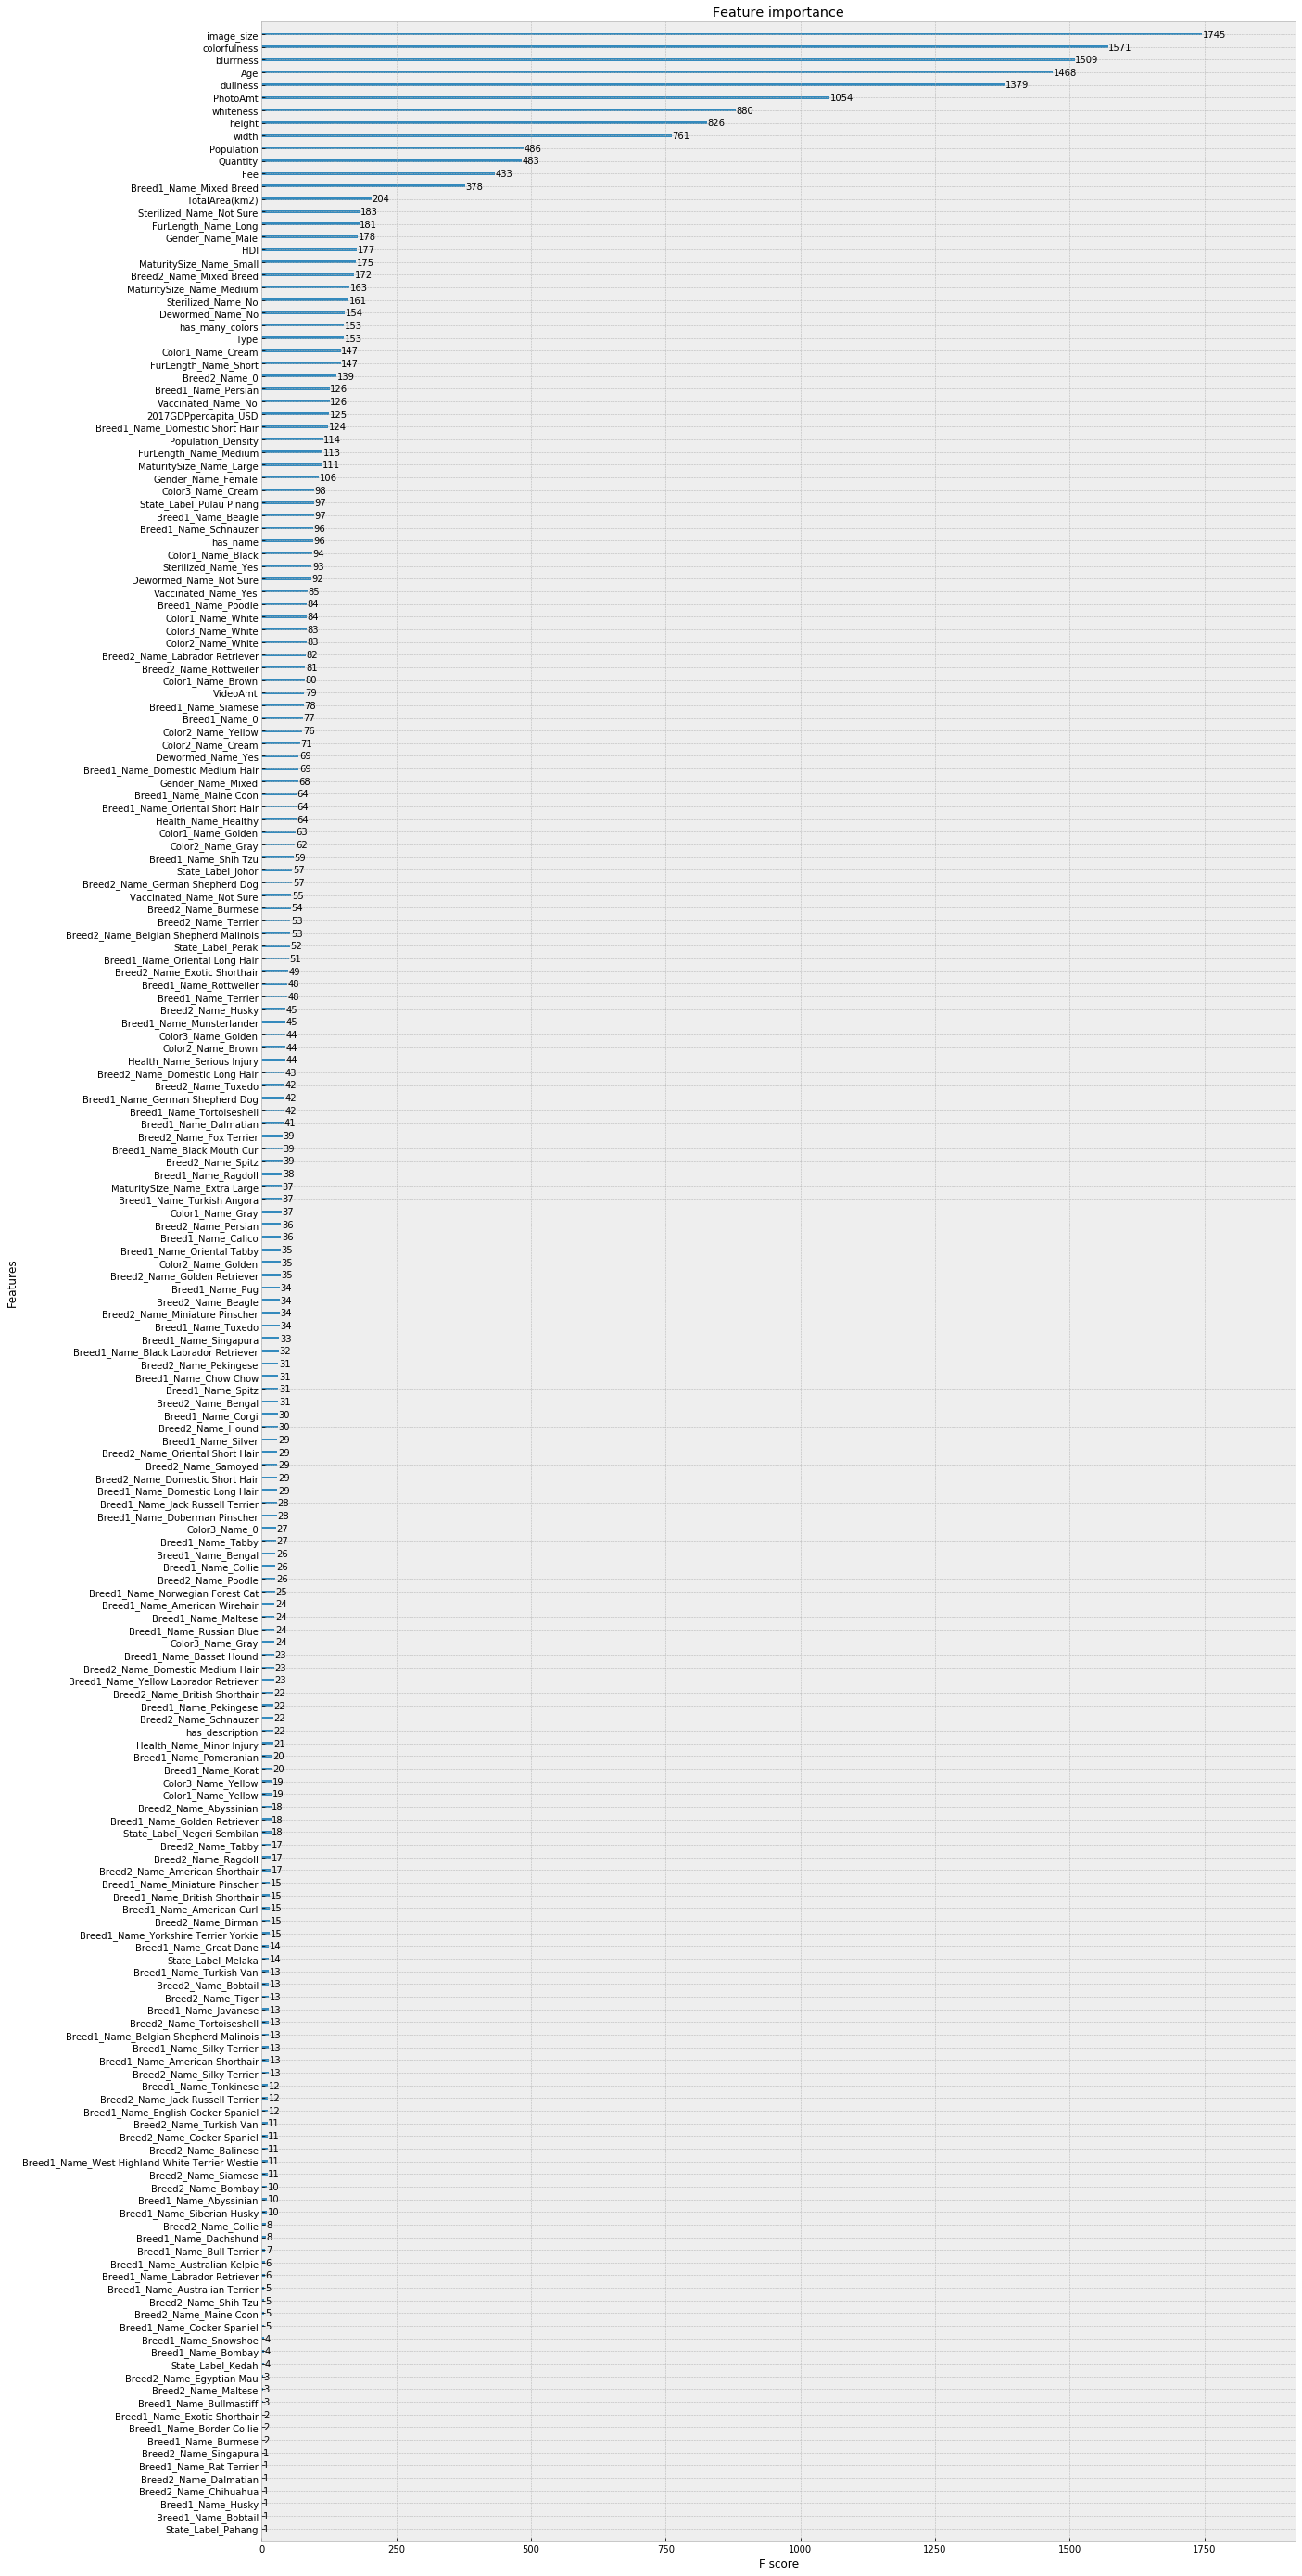

In [25]:
f, ax = plt.subplots(figsize=(20, 50))
xgb.plot_importance(bst, ax=ax)

Text(0.5,1,'Top 25 Feature importance')

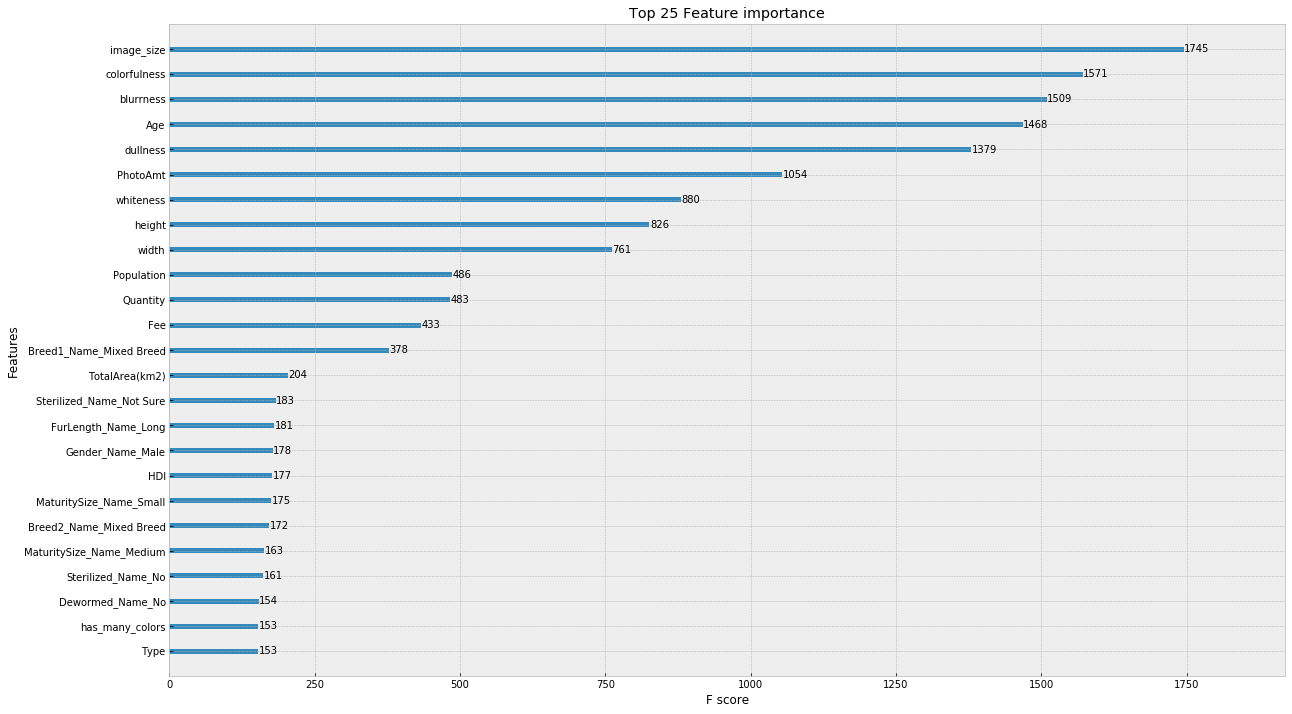

In [26]:
f, ax = plt.subplots(figsize=(20, 12))
xgb.plot_importance(bst, ax=ax, max_num_features= 25)
plt.title('Top 25 Feature importance')